<a href="https://colab.research.google.com/github/koushikroy/facial_sentiment_analysis/blob/main/04_sentiment_model_jafee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Jafee Dataset, Conv Model**

# Loading Dataset

In [1]:
# Downloading Dataset
!wget 'https://github.com/koushikroy/facial_sentiment_analysis/blob/main/dataset/jaffe/Jaffe_Image_Dataset_train_test.rar?raw=true'

--2021-07-14 18:56:09--  https://github.com/koushikroy/facial_sentiment_analysis/blob/main/dataset/jaffe/Jaffe_Image_Dataset_train_test.rar?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/koushikroy/facial_sentiment_analysis/raw/main/dataset/jaffe/Jaffe_Image_Dataset_train_test.rar [following]
--2021-07-14 18:56:10--  https://github.com/koushikroy/facial_sentiment_analysis/raw/main/dataset/jaffe/Jaffe_Image_Dataset_train_test.rar
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/koushikroy/facial_sentiment_analysis/main/dataset/jaffe/Jaffe_Image_Dataset_train_test.rar [following]
--2021-07-14 18:56:10--  https://raw.githubusercontent.com/koushikroy/facial_sentiment_analysis/main/dataset/jaffe/Jaffe_Image_Dataset_train_test.rar
Resolvin

In [2]:
!unrar x "/content/Jaffe_Image_Dataset_train_test.rar?raw=true" "/content"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/Jaffe_Image_Dataset_train_test.rar?raw=true

Creating    /content/Jaffe_Image_Dataset_train_test                   OK
Creating    /content/Jaffe_Image_Dataset_train_test/train             OK
Creating    /content/Jaffe_Image_Dataset_train_test/train/Angry       OK
Extracting  /content/Jaffe_Image_Dataset_train_test/train/Angry/KA.AN1.39.tiff       0%  OK 
Extracting  /content/Jaffe_Image_Dataset_train_test/train/Angry/KA.AN3.41.tiff       0%  OK 
Extracting  /content/Jaffe_Image_Dataset_train_test/train/Angry/KL.AN1.167.tiff       1%  OK 
Extracting  /content/Jaffe_Image_Dataset_train_test/train/Angry/KL.AN2.168.tiff       1%  OK 
Extracting  /content/Jaffe_Image_Dataset_train_test/train/Angry/KM.AN1.17.tiff       2%  OK 
Extracting  /content/Jaffe_Image_Dataset_train_test/train/Angry/KM.AN2.18.tiff       2%  OK 
Extracting  /content/Jaffe_I

# Data Preprocessing

## Imports

In [3]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

## Train Validation Generator with Augmentation
Image Size = Width: 40, Height: 25 
Maybe Resize = 50,50

In [23]:
IMAGE_SIZE = 150
TRAINING_DIR = "/content/Jaffe_Image_Dataset_train_test/train"
training_datagen = ImageDataGenerator(
     rescale = 1./255,
)
# training_datagen = ImageDataGenerator(
#       rescale = 1./255,
# 	    rotation_range=40,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=False,
#       fill_mode='nearest')

VALIDATION_DIR = "/content/Jaffe_Image_Dataset_train_test/validation"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(IMAGE_SIZE,IMAGE_SIZE),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(IMAGE_SIZE,IMAGE_SIZE),
	class_mode='categorical',
  batch_size=35
)

Found 178 images belonging to 7 classes.
Found 35 images belonging to 7 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/utils.py:179: UserWarning: Using ".tiff" files with multiple bands will cause distortion. Please verify your output.
  warnings.warn('Using ".tiff" files with multiple bands '


In [5]:
178 / 32

5.5625

In [7]:
len(train_generator)

6

In [8]:
train_generator.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'SAD': 5,
 'Surprise': 6}

# Transfer Learning 

In [7]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [14]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_layer") # shape of input image
#x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(inputs, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
x = layers.Dense(32, activation="relu", name="dense")(x)
outputs = layers.Dense(7, activation="softmax", name="output_layer")(x) # same number of outputs as classes
model_efficient = tf.keras.Model(inputs, outputs)

In [15]:
model_efficient.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                40992     
_________________________________________________________________
output_layer (Dense)         (None, 7)                 231       
Total params: 4,090,794
Trainable params: 41,223
Non-trainable params: 4,049,571
_________________________________________________________________


In [16]:
# Compile
model_efficient.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model_efficient.fit(train_generator,
                                           epochs=30) # fit for 5 epochs to keep experiments quick
                                           #validation_data=test_data,
                                           #validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           #callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/30
7/7 [==============================] - 5s 80ms/step - loss: 1.9504 - accuracy: 0.1408
Epoch 2/30
7/7 [==============================] - 1s 76ms/step - loss: 1.9491 - accuracy: 0.1502
Epoch 3/30
7/7 [==============================] - 1s 77ms/step - loss: 1.9462 - accuracy: 0.1502
Epoch 4/30
7/7 [==============================] - 1s 81ms/step - loss: 1.9461 - accuracy: 0.1502
Epoch 5/30
7/7 [==============================] - 1s 76ms/step - loss: 1.9464 - accuracy: 0.1502
Epoch 6/30
7/7 [==============================] - 1s 75ms/step - loss: 1.9464 - accuracy: 0.1502
Epoch 7/30
7/7 [==============================] - 1s 77ms/step - loss: 1.9463 - accuracy: 0.1502
Epoch 8/30
7/7 [==============================] - 1s 77ms/step - loss: 1.9462 - accuracy: 0.1502
Epoch 9/30
7/7 [==============================] - 1s 78ms/step - loss: 1.9463 - accuracy: 0.1502
Epoch 10/30
7/7 [==============================] - 1s 76ms/step - loss: 1.9461 - accuracy: 0.1502
Epoch 11/30
7/7 [============

# Model Conv

### Basic Conv Model
Some Clarification:

1.   **Steps Per Epoch:** It is normally the number of unique samples in training set / batch size = 14400 / 128
2.   **Validation Steps:** Same as above. Replace training with validation.



In [9]:
IMAGE_SIZE

150

In [19]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [20]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history = model.fit(train_generator,
                    epochs=30, # fit for 5 epochs to keep experiments quick
                                           validation_data=validation_generator,
                                           validation_steps=int(len(validation_generator)), # evaluate on smaller portion of test data
                                           ) # save best model weights to file

Epoch 1/30
6/6 [==============================] - 2s 209ms/step - loss: 2.4434 - accuracy: 0.1461 - val_loss: 1.9493 - val_accuracy: 0.1429
Epoch 2/30
6/6 [==============================] - 1s 179ms/step - loss: 1.9475 - accuracy: 0.1348 - val_loss: 1.9463 - val_accuracy: 0.1143
Epoch 3/30
6/6 [==============================] - 1s 185ms/step - loss: 1.9473 - accuracy: 0.1292 - val_loss: 1.9473 - val_accuracy: 0.0857
Epoch 4/30
6/6 [==============================] - 1s 193ms/step - loss: 1.9451 - accuracy: 0.1404 - val_loss: 1.9470 - val_accuracy: 0.1143
Epoch 5/30
6/6 [==============================] - 1s 191ms/step - loss: 1.9492 - accuracy: 0.1124 - val_loss: 1.9459 - val_accuracy: 0.1714
Epoch 6/30
6/6 [==============================] - 1s 187ms/step - loss: 1.9451 - accuracy: 0.0955 - val_loss: 1.9458 - val_accuracy: 0.1714
Epoch 7/30
6/6 [==============================] - 1s 189ms/step - loss: 1.9484 - accuracy: 0.1461 - val_loss: 1.9458 - val_accuracy: 0.1429
Epoch 8/30
6/6 [====

In [24]:
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=[tf.keras.metrics.Precision(), 
                                                                               tf.keras.metrics.Recall(),
                                                                               'accuracy'])

history = model.fit(train_generator, 
                    epochs=25, 
                    steps_per_epoch=len(train_generator), 
                    #validation_data = validation_generator, 
                    verbose = 1
                    #validation_steps=20
                    )

#model.save("/tmp/models/conv_1.h5")

Epoch 1/25


ResourceExhaustedError: ignored

In [ ]:
14400 / 128, 3600 / 128

(112.5, 28.125)

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=150,
)

**Model Performace Evaluation**

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

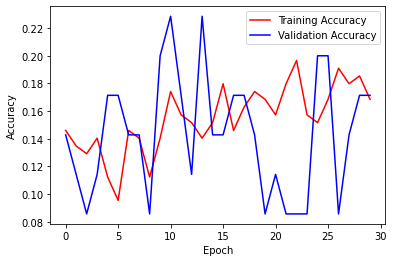

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
#precision = history.history['precision']
#val_precision = history.history['val_precision']

#recall = history.history['recall']
#val_recall = history.history['val_recall']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
#plt.title('Training and validation accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(loc=0)
plt.figure()


plt.show()

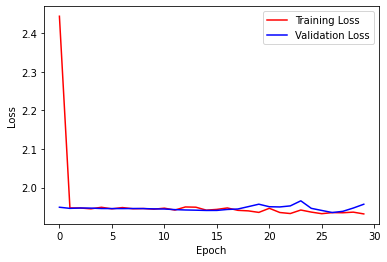

<Figure size 432x288 with 0 Axes>

In [22]:
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
#plt.title('Training and validation accuracy')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc=0)
plt.figure()


plt.show()

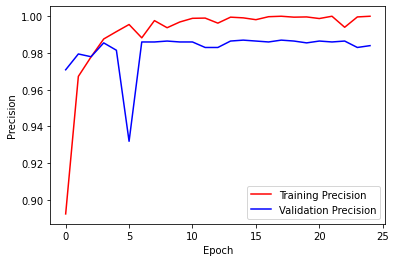

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, precision, 'r', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
#plt.title('Training and validation accuracy')
plt.ylabel("Precision")
plt.xlabel("Epoch")
plt.legend(loc=0)
plt.figure()


plt.show()

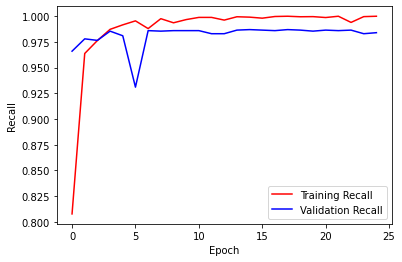

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs, recall, 'r', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
#plt.title('Training and validation accuracy')
plt.ylabel("Recall")
plt.xlabel("Epoch")
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/sample_data/conv_1')

In [ ]:
!unrar x "/content/sample_data/conv_1.rar" "/content/sample_data"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/sample_data/conv_1.rar

Creating    /content/sample_data/conv_1                               OK
Extracting  /content/sample_data/conv_1/keras_metadata.pb                  0%  OK 
Extracting  /content/sample_data/conv_1/saved_model.pb                     0%  OK 
Creating    /content/sample_data/conv_1/variables                     OK
Extracting  /content/sample_data/conv_1/variables/variables.data-00000-of-00001      43% 87% 99%  OK 
Extracting  /content/sample_data/conv_1/variables/variables.index         99%  OK 
Creating    /content/sample_data/conv_1/assets                        OK
All OK


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

class_list = ["down", "left", "middle", "right", "up"]

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(50, 50))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  #print(classes)
  for i in range(classes.shape[1]):
    if classes[0,i] == 1:
      print(class_list[i])                

Saving eye_leftup9.jpg to eye_leftup9.jpg
Saving eye_leftup928.jpg to eye_leftup928.jpg
Saving eye_leftup993.jpg to eye_leftup993.jpg
eye_leftup9.jpg
up
eye_leftup928.jpg
up
eye_leftup993.jpg
up


In [ ]:
for i in range(classes.shape[1]):
  if classes[0,i] == 1:
    print(class_list[i])

lower_left


In [ ]:
classes.shape[1]

9

# Confusion

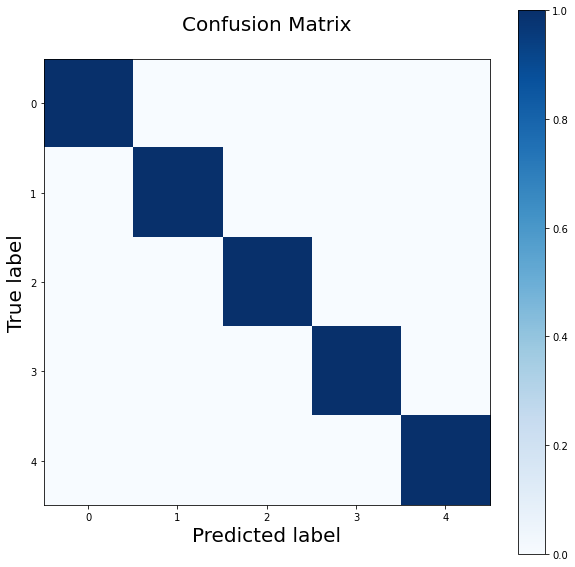

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
data = []     # store all the generated data batches
labels = []   # store all the generated label batches
max_iter = 36  # maximum number of iterations, in each iteration one batch is generated; the proper value depends on batch size and size of whole data
i = 0
for d, l in validation_generator:
    data.append(d)
    labels.append(l)
    i += 1
    if i == max_iter:
        break

data = np.array(data)
data = np.reshape(data, (data.shape[0]*data.shape[1],) + data.shape[2:])

labels = np.array(labels)
labels = np.reshape(labels, (labels.shape[0]*labels.shape[1],) + labels.shape[2:])


X_test, y_test = data, labels

y_preds = model.predict(X_test)


# Create a confusion matrix
#import itertools
from sklearn.metrics import confusion_matrix

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb 

figsize = (10, 10)

# Create the confusion matrix
cm = confusion_matrix(tf.argmax(tf.constant(y_test)), tf.argmax(tf.round(y_preds)))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
fig.colorbar(cax)

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom()

# Adjust label size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.title.set_size(20)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#   plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
#            horizontalalignment="center",
#            color="white" if cm[i, j] > threshold else "black",
#            size=15)